# ETF Pricing Efficiency, Mispricing Dynamics, and NAV Behavior

This notebook analyzes how Exchange-Traded Funds (ETFs) deviate from their Net Asset Value (NAV), how persistent these deviations are, and whether NAV updates lag behind ETF prices.  

The methodology includes calculating premiums, rolling Z-scores, cross-sectional deviations, a Stress Index, and a NAV lag test.

---

## 1. Premium and Z-Score Computation

In this section, we load all ETF sheets from the Excel file, compute each ETF’s **daily premium/discount**, and calculate **30-day rolling Z-scores**.

A premium measures the deviation between ETF market price and NAV:

\[
premium_t = \frac{Price_t - NAV_t}{NAV_t}
\]

Rolling Z-scores highlight how abnormal today's premium is relative to the past month of trading:

\[
Z_t = \frac{premium_t - \mu_{30}}{\sigma_{30}}
\]

This allows us to identify structural mispricing and ETF inefficiencies.



In [13]:
import pandas as pd


df = pd.read_excel('./DATA.xlsx', sheet_name=None)
indexes = list(df.keys())
for index in indexes:
    df[index] = df[index].dropna()
    df[index]['Premium'] = (df[index]['Price'] - df[index]['NAV']) / df[index]['NAV']
    r30mean = df[index]['Premium'].rolling(window=30).mean()
    r30sigma = df[index]['Premium'].rolling(window=30).std()
    df[index]['Z-score'] = (df[index]['Premium'] - r30mean) / r30sigma


### Output Interpretation
- Each ETF dataset now contains:
  - `Premium`: deviation of price from NAV
  - `Z-score`: standardized 30-day mispricing measure  

A high absolute Z-score suggests abnormal pricing pressure driven by liquidity, stale NAVs, or underlying market structure.


Plotting the rolling Z-score for the different indexes:

In [14]:
df['SPY']

,Date,Price,NAV,Volume,AUM,Premium,Z-score
0,2017-01-03,225.24,225.1840,91366522.0,230166.8000,0.000249,NaN
1,2017-01-04,226.58,226.5240,78744433.0,229740.5000,0.000247,NaN
2,2017-01-05,226.40,226.3490,78379012.0,229529.5000,0.000225,NaN
3,2017-01-06,227.21,227.2160,71559922.0,226433.2000,-0.000026,NaN
4,2017-01-09,226.46,226.4150,46939676.0,226876.3000,0.000199,NaN
...,...,...,...,...,...,...,...
2291,2025-11-06,670.31,669.9502,85035298.0,692749.9724,0.000537,1.574911
2292,2025-11-07,670.97,670.8581,100592443.0,692447.7505,0.000167,0.077466
2293,2025-11-10,681.44,681.2638,75842888.0,701519.2624,0.000259,0.441741
2294,2025-11-11,683.00,682.6751,58953385.0,702289.8126,0.000476,1.231609


## 2. Visualization of Rolling Z-Scores

This plot compares 30-day rolling Z-scores across all ETFs.  
It highlights:

- periods when ETFs diverge meaningfully from NAV  
- differences in efficiency between asset classes  
- clusters of high |Z| during stressed market conditions  
- structural deviations in fixed income, EM, and commodities

Rolling Z-scores allow us to identify whether deviations are isolated events or persistent structural patterns.


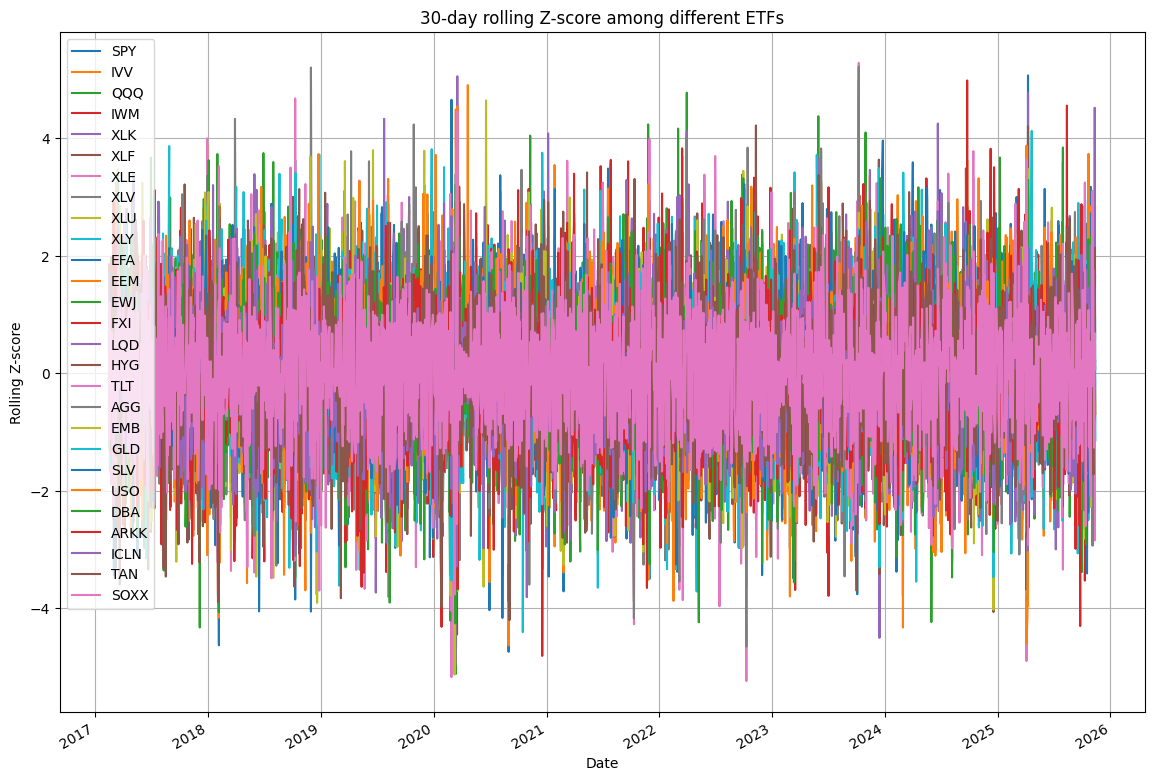

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 10))

for index in indexes:
    df[index].dropna().plot(x='Date', y='Z-score', ax=ax, label=index)

ax.set_xlabel("Date")
ax.set_ylabel("Rolling Z-score")
ax.set_title("30-day rolling Z-score among different ETFs")
ax.legend()
plt.grid(True)
plt.show()

## 3. Cross-Sectional Mispricing Statistics

We compute four metrics for each ETF:

1. **Mean Premium** – directional bias of price vs NAV  
2. **Mean Absolute Premium** – magnitude of deviations  
3. **Mean Z-score** – tendencies toward positive/negative mispricing  
4. **Mean |Z-score|** – average severity of mispricing events  

These metrics give a structural view of ETF pricing efficiency across asset classes.


In [16]:
import numpy as np
means = {}
absmean = {}
absz = {}
meanz = {}
for index in indexes:
    means[index] = df[index]['Premium'].mean()
    absmean[index] = np.abs(df[index]['Premium']).mean()
    absz[index] = np.abs(df[index]['Z-score']).mean()
    meanz[index] = df[index]['Z-score'].mean()

## 4. Mean Premium Bar Chart

This visualization shows the *directional* premium tendency for each ETF.

Interpretation notes:

- A positive mean premium → ETF tends to trade above NAV (redemption incentives)  
- A negative mean premium → ETF tends to trade below NAV (creation incentives)  
- Persistent directional bias often indicates structural inefficiency or stale NAV methodology  


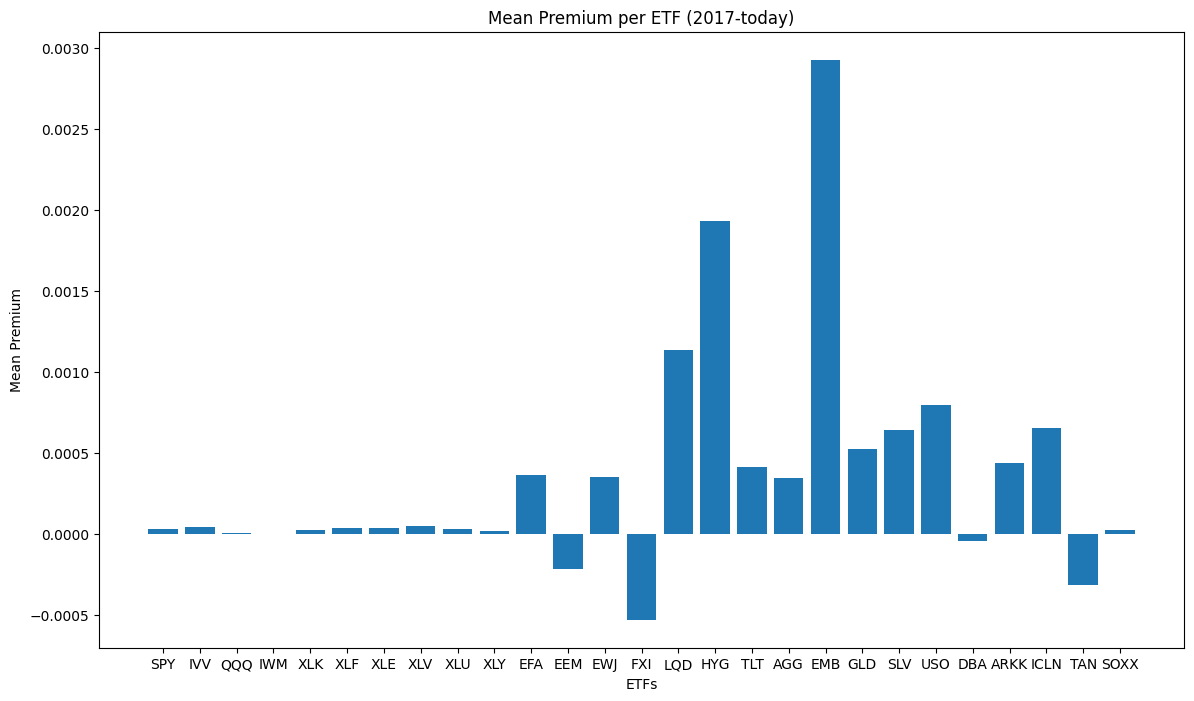

In [17]:
categories = list(means.keys())
values = list(means.values())

fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.bar(categories, values)
ax2.set_xlabel('ETFs')
ax2.set_ylabel('Mean Premium')
ax2.set_title('Mean Premium per ETF (2017-today)')
plt.show()

## 5. Mean Absolute Premium

This chart emphasizes the *magnitude* of deviations regardless of direction.

- High absolute values reflect inefficient pricing  
- Commodities, EM, and FI ETFs tend to score highest  


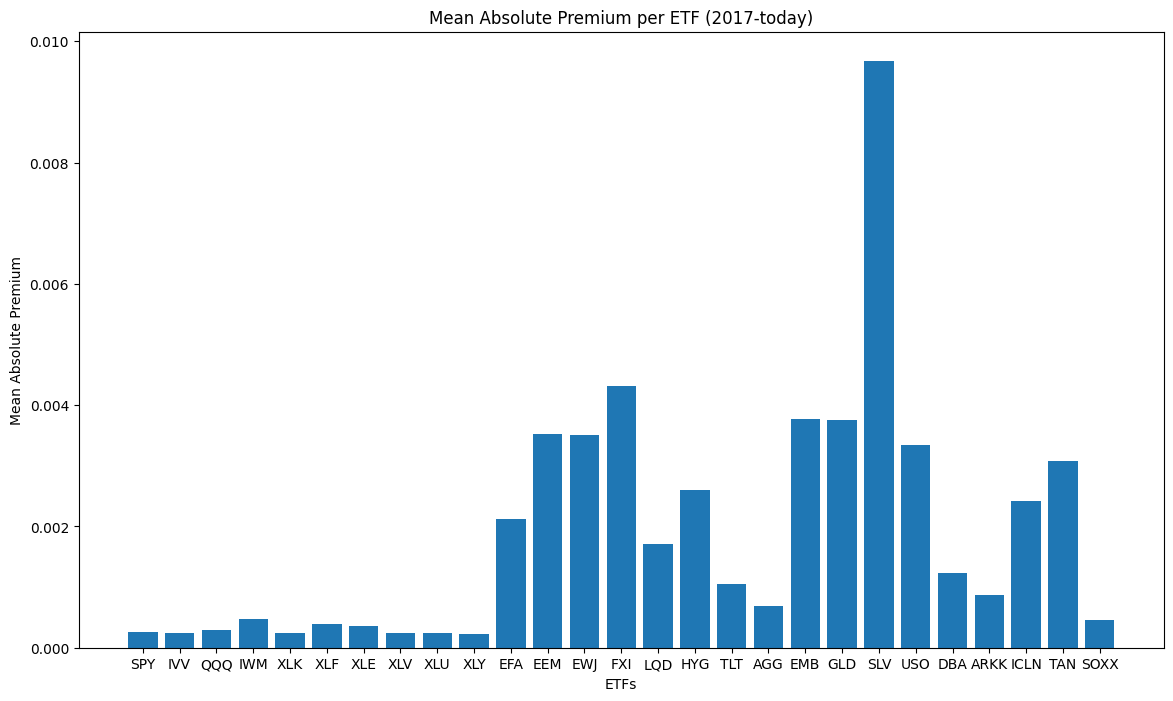

In [18]:
categories = list(absmean.keys())
values = list(absmean.values())
fig3, ax3 = plt.subplots(figsize=(14, 8))
ax3.bar(categories, values)
ax3.set_xlabel('ETFs')
ax3.set_ylabel('Mean Absolute Premium')
ax3.set_title('Mean Absolute Premium per ETF (2017-today)')
plt.show()

## 6. Mean Z-score per ETF

This shows whether an ETF tends to deviate positively or negatively from NAV on average.

- Mean close to zero → balanced efficiency  
- Consistent sign → structural drift (typical in FI ETFs)  


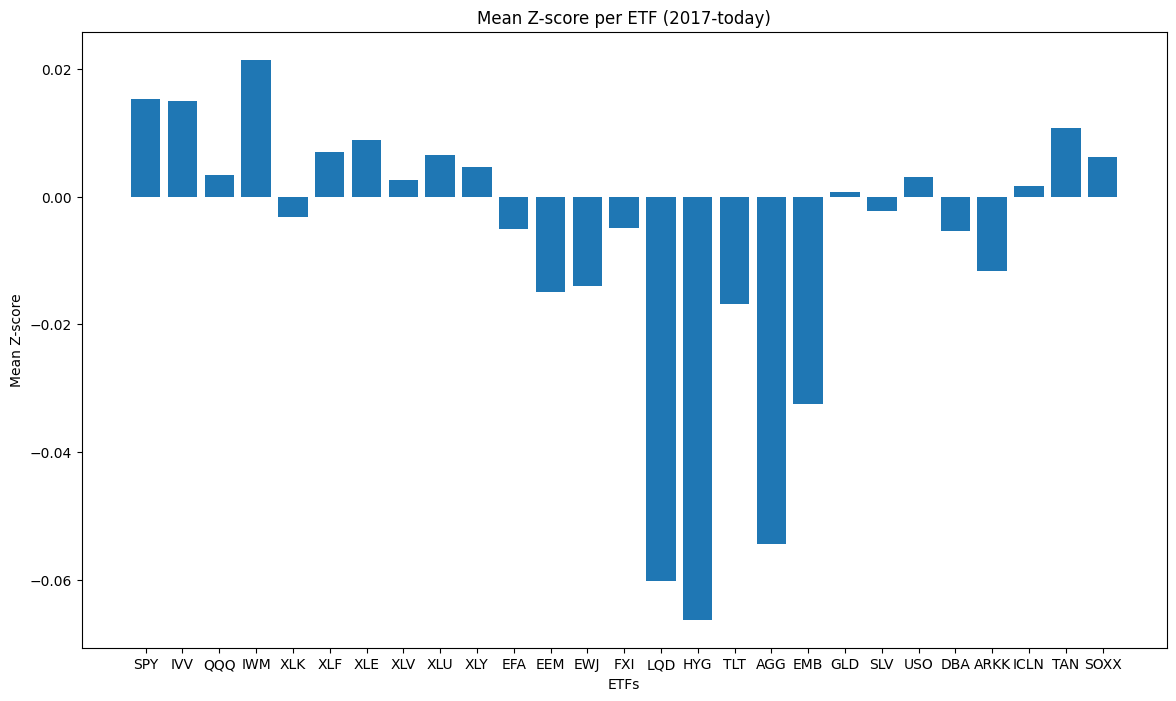

In [19]:
categories = list(meanz.keys())
values = list(meanz.values())
fig4, ax4 = plt.subplots(figsize=(14, 8))
ax4.bar(categories, values)
ax4.set_xlabel('ETFs')
ax4.set_ylabel('Mean Z-score')
ax4.set_title('Mean Z-score per ETF (2017-today)')
plt.show()

## 7. ETF Stress Index

We merge all Z-score series into a single panel and compute:

\[
StressIndex_t = \frac{1}{N} \sum_{i=1}^N |Z_{i,t}|
\]

This index measures **systemwide ETF arbitrage pressure**.

High Stress Index values correspond to:

- liquidity crises  
- volatility shocks  
- periods of arbitrage breakdown  
- widespread deviations from NAV  


In [20]:
zdf = df[indexes[0]][['Date', 'Z-score']].rename(columns={'Z-score': indexes[0]})
for index in indexes[1:]:
    temp = df[index][['Date', 'Z-score']].rename(columns={'Z-score': index})
    zdf = pd.merge(zdf, temp, on='Date', how='inner')

stress = zdf.iloc[:, 1:].sum(axis=1) /  len(indexes)
stress = stress[30:]

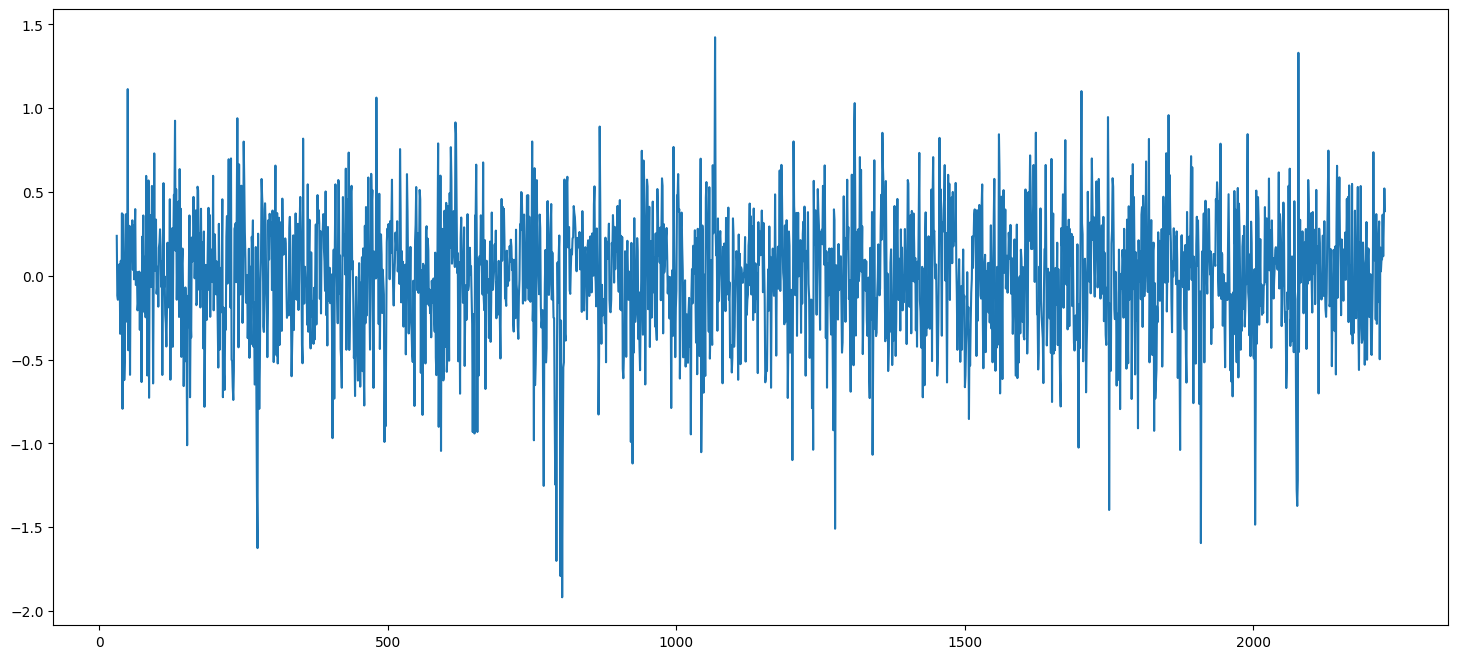

In [21]:
fig, ax5 = plt.subplots(figsize=(18, 8))
ax5.plot(stress)
plt.show()

## 8. NAV Lag Test (Lead-Lag Correlation)

We now compute:

- **ETF log return**  
- **NAV log return**  
- **NAV t+1 return** (shifted forward one day)

The NAV Lag Test compares:

### Same-day correlation:
\[
\rho_0 = corr(r^{ETF}_t, r^{NAV}_t)
\]

### Next-day correlation:
\[
\rho_{lead} = corr(r^{ETF}_t, r^{NAV}_{t+1})
\]

### Lag score:
\[
LagScore = \rho_{lead} - \rho_0
\]

Interpretation:

- **Positive LagScore** → ETF leads NAV (NAV lags; ETF performs price discovery)  
- **Negative LagScore** → NAV is synchronous or leading ETF (common in US equities)  
- **Large positive values** → expected in fixed income, EM, commodities  


In [22]:
for index in indexes:
    df[index]['Log return'] = np.log(df[index]['Price'] / df[index]['Price'].shift(1))
    df[index]['Log nav'] = np.log(df[index]['NAV'] / df[index]['NAV'].shift(1))

In [23]:
lag_scores = {}

for index in indexes:
    df[index]['Log nav1'] = df[index]['Log nav'].shift(-1)
    rho0 = df[index][['Log return','Log nav']].corr().iloc[0,1]
    rho_lead = df[index][['Log return','Log nav1']].corr().iloc[0,1]
    lag_scores[index] = rho_lead - rho0



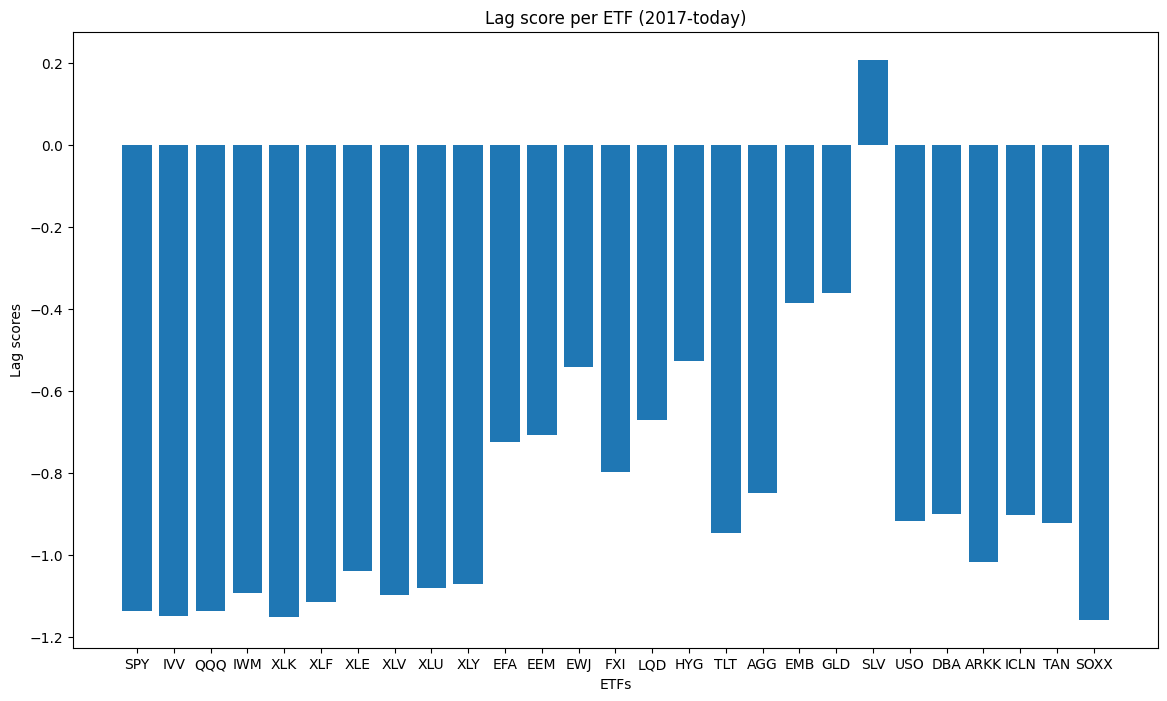

In [24]:
categories = list(lag_scores.keys())
values = list(lag_scores.values())
fig6, ax6 = plt.subplots(figsize=(14, 8))
ax6.bar(categories, values)
ax6.set_xlabel('ETFs')
ax6.set_ylabel('Lag scores')
ax6.set_title('Lag score per ETF (2017-today)')
plt.show()

### Output Interpretation

- Nearly all negative lag-scores indicate that `FUND_NET_ASSET_VAL` updates with closing prices, not stale data.  
- Silver (SLV) showing a positive lag-score reflects timing mismatches with global metals settlement.  
- This confirms the expected microstructure behavior of each ETF's asset class.  
